In [1]:
import torch
import torch.nn as nn
import scanpy as sc
import numpy as np
import h5py

from MaskedLinear import MaskedLinear

from slalom import plotFactors

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 15)

In [4]:
adata = sc.read('mouse_retina_sbs.h5ad')

In [5]:
select_genes = adata.varm['I'].sum(1)>0

In [6]:
adata._inplace_subset_var(select_genes)

In [7]:
adata.X-=adata.X.mean(0)

In [8]:
EPOCH = 15
BATCH_SIZE = 70
LR = 0.005
ALPHA = 0.35

In [9]:
class MaskedAutoencoder(nn.Module):
    def __init__(self, n_vars, n_terms, n_latent, estimator='ST', f_eval='Mode'):
        super().__init__()
        
        self.encoder = nn.Sequential(
            MaskedLinear(n_vars, n_terms, estimator, f_eval, bias=False),
            nn.ELU(),
            nn.Linear(n_terms, n_latent)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(n_latent, n_terms),
            nn.ELU(),
            nn.Linear(n_terms, n_vars),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [10]:
def get_loss_func(I, alpha):
    l2_loss = nn.MSELoss()
    bce_loss = nn.BCEWithLogitsLoss()
    
    def regularized_loss(X, Y, logits):
        return l2_loss(X, Y), alpha*bce_loss(logits, I.t())
    
    return regularized_loss

In [11]:
def train_autoencoder(autoencoder, loss_func):
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
    
    t_X = torch.from_numpy(adata.X)
    
    logits = autoencoder.encoder[0].logits

    for epoch in range(EPOCH):
        autoencoder.train()
        for step in range(int(adata.n_obs/BATCH_SIZE)):
            batch = torch.from_numpy(adata.chunk_X(BATCH_SIZE))
            optimizer.zero_grad()
            batch_loss = 0
            
            for sample in batch:
                sample = sample[None, :]
                encoded, decoded = autoencoder(sample)
                
                loss = sum(loss_func(decoded, sample, logits))/BATCH_SIZE
                loss.backward()
                
                batch_loss += loss.data
            
            optimizer.step()
            if step % 100 == 0: print('Epoch: ', epoch, '| batch train loss: %.4f' % batch_loss.numpy())
        autoencoder.eval()
        _, t_decoded = autoencoder(t_X)
        
        t_loss = loss_func(t_decoded, t_X, logits)
        t_loss = [sum(t_loss)] + list(t_loss)
        t_loss = [l.data.numpy() for l in t_loss]
        
        print('Epoch: ', epoch, '-- total train loss: %.4f=%.4f+%.4f' % tuple(t_loss))

In [12]:
autoencoder = MaskedAutoencoder(adata.n_vars, len(adata.uns['terms']), 10)

In [14]:
I = torch.from_numpy(adata.varm['I']).float()
loss_func = get_loss_func(I, ALPHA)

In [15]:
train_autoencoder(autoencoder, loss_func)

Epoch:  0 | batch train loss: 0.4448
Epoch:  0 | batch train loss: 0.3362
Epoch:  0 -- total train loss: 0.3058=0.1699+0.1359
Epoch:  1 | batch train loss: 0.2905
Epoch:  1 | batch train loss: 0.2659
Epoch:  1 -- total train loss: 0.2486=0.1653+0.0833
Epoch:  2 | batch train loss: 0.2330
Epoch:  2 | batch train loss: 0.2214
Epoch:  2 -- total train loss: 0.2191=0.1629+0.0563
Epoch:  3 | batch train loss: 0.2218
Epoch:  3 | batch train loss: 0.2194
Epoch:  3 -- total train loss: 0.2022=0.1612+0.0411
Epoch:  4 | batch train loss: 0.2051
Epoch:  4 | batch train loss: 0.1896
Epoch:  4 -- total train loss: 0.1925=0.1608+0.0317
Epoch:  5 | batch train loss: 0.1935
Epoch:  5 | batch train loss: 0.1952
Epoch:  5 -- total train loss: 0.1850=0.1595+0.0256
Epoch:  6 | batch train loss: 0.1809
Epoch:  6 | batch train loss: 0.1875
Epoch:  6 -- total train loss: 0.1806=0.1593+0.0213
Epoch:  7 | batch train loss: 0.1724
Epoch:  7 | batch train loss: 0.1704
Epoch:  7 -- total train loss: 0.1768=0.1586

In [17]:
t_X = torch.from_numpy(adata.X)

In [18]:
adata.obsm['X_encoded'] = autoencoder.encoder[1](autoencoder.encoder[0](t_X)[:, [132, 139]].data).numpy()

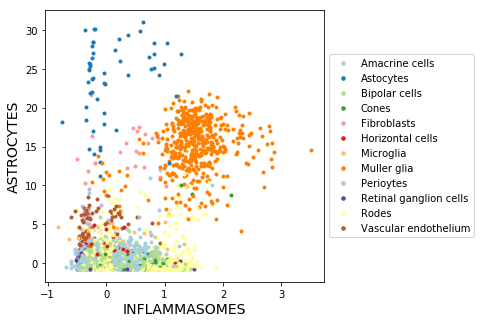

In [19]:
fg = plotFactors(terms=['INFLAMMASOMES', 'ASTROCYTES'], X=adata.obsm['X_encoded'], lab=adata.obs['cell_type'], isCont=False)

In [34]:
torch.save(autoencoder, 'auto_2nd_linear.pt')